Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from typing import Tuple
torch.manual_seed(0)
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2$.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

Test split ratio: 0.33


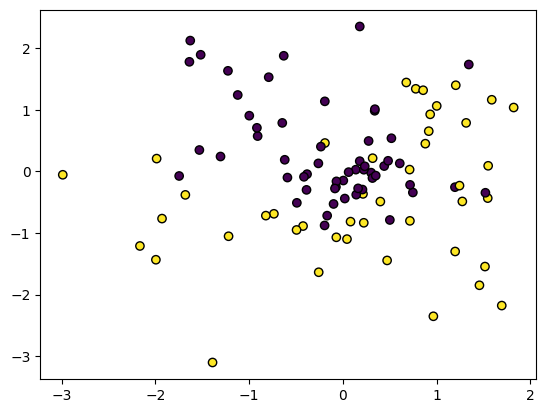

In [38]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');
#plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="x", alpha=0.5);
print(f"Test split ratio: {X_test.shape[0]/(X_train.shape[0] + X_test.shape[0]):.2}")

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [39]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [40]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [41]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """
    log_w = dist.MultivariateNormal(torch.zeros_like(w), covariance_matrix=torch.eye(w.shape[0])*sigma**2).log_prob(w)
    log_y = dist.Bernoulli(predict_probs_MAP(Phi, w)).log_prob(y)
    return log_w.sum() + log_y.sum()

In [42]:
# (GRADING)

In [43]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [44]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """
    epochs = 25
    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    opt = torch.optim.Adagrad([weights], lr=0.1)
    losses = []
    for epoch in range(epochs):
        opt.zero_grad()
        log_p = log_joint(Phi, y, weights)
        loss = -log_p.sum()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return weights.detach(), losses


def batch_gen(Phi: torch.Tensor, y: torch.Tensor, bs: int) -> Tuple[torch.Tensor, torch.Tensor]:
    assert Phi.shape[0] == y.shape[0]
    index = torch.randperm(y.shape[0])
    for ind in range(0, y.shape[0], bs):
        index_slice = index[ind:ind+bs]
        yield Phi[index_slice, :], y[index_slice]

### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

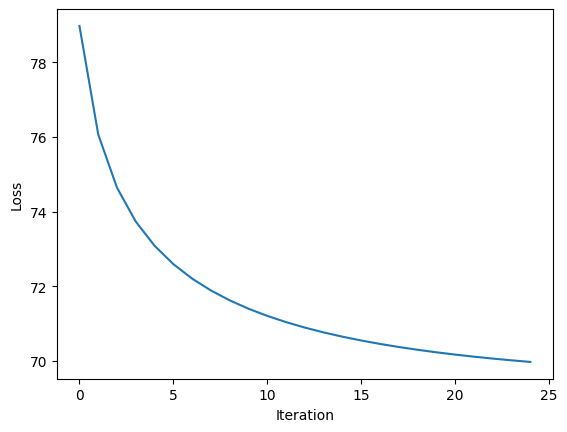

In [45]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

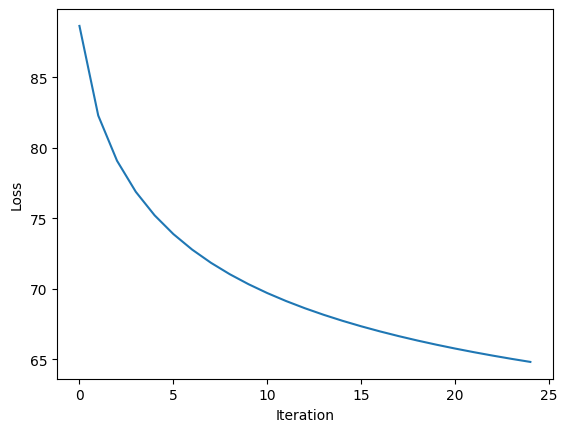

In [46]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [47]:
# (GRADING)

In [48]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [49]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.67, test accuracy = 0.70


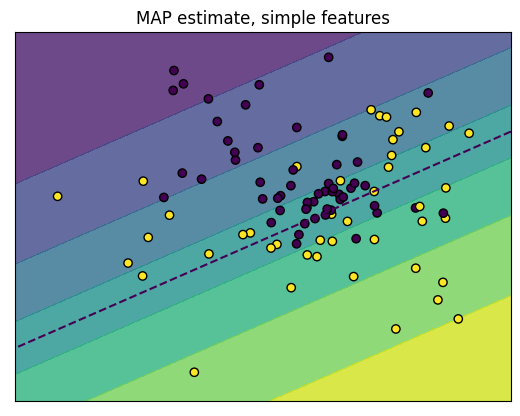

In [50]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


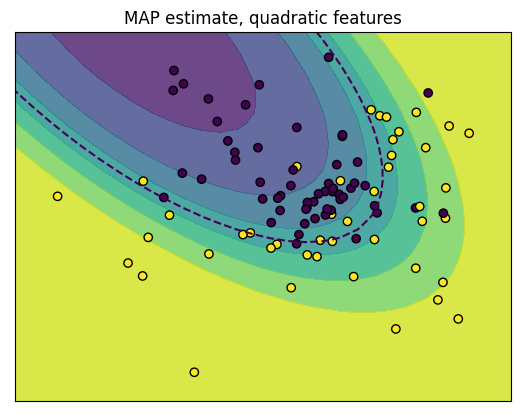

In [51]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [52]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    y_hat = predict_probs_MAP(Phi, w_MAP)
    D = torch.eye(Phi.shape[0])* y_hat * (1 - y_hat)
    sn_inv = torch.eye(w_MAP.shape[0]) * prior_std**-2 + Phi.T @ D @ Phi
    assert sn_inv.shape[0] == sn_inv.shape[1] == w_MAP.shape[0]
    return torch.linalg.inv(sn_inv)



In [53]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    assert w_MAP.shape[0] == Cov.shape[0] == Cov.shape[1]
    q_w = dist.MultivariateNormal(loc=w_MAP, covariance_matrix=Cov)
    y_hat = torch.zeros(Phi.shape[0])
    for i, phi in enumerate(Phi):
        # Peforms MonteCarlo estimate of the integral in point 2 above
        # Increase number of samples for higher precision on integral value.
        # This Operation could be vectorised quite easily however this is
        # clearer and so we leave the loop.
        w = q_w.sample((10000,))
        y_hat[i] = predict_probs_MAP(phi, w.T).mean()
    return y_hat

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [54]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)


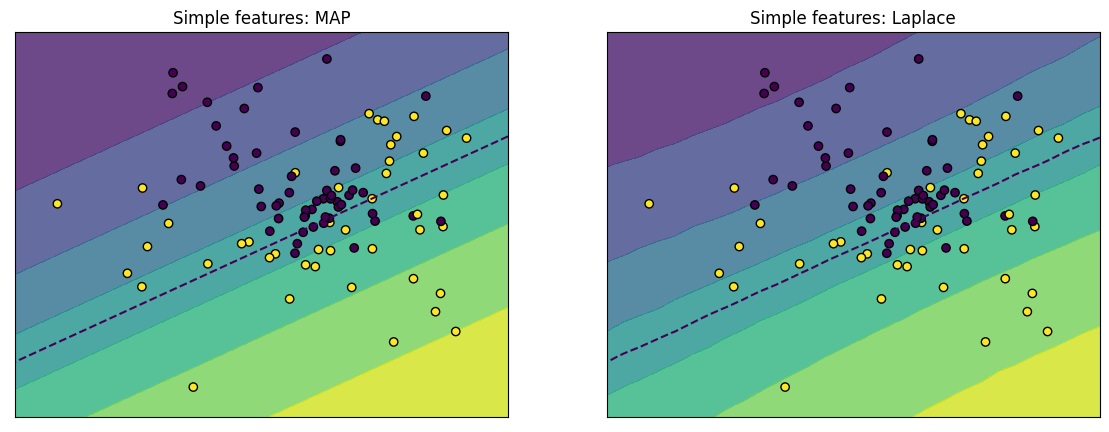

In [55]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [56]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

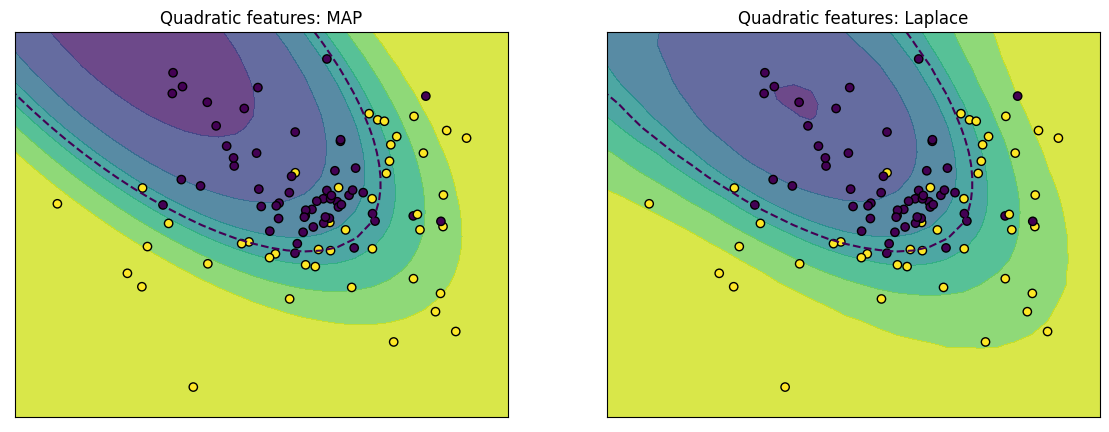

In [57]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [58]:
# (GRADING)

In [59]:
# (GRADING)

In [60]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [61]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    occam_factor =(
                - 1/2*torch.linalg.det(Cov).log()
                + w_MAP.shape[0]/2*torch.log(torch.tensor(2*torch.pi))
    )
    return occam_factor + log_joint(Phi, y, w_MAP)


In [62]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())
Cov_quad_test = compute_laplace_Cov(features_quadratic(X_test), y_test, w_MAP_quad)
print("Model evidence estimate(Test)(polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_test), y_test, w_MAP_quad, Cov_quad_test).item())


Model evidence estimate (simple features): -62.71108627319336
Model evidence estimate (polynomial features): -50.79100799560547
Model evidence estimate(Test)(polynomial features): -24.03831672668457


In [63]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [64]:
def features_student(X):
    """
    Compute your own, custom set of features!
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    ## Dum non vectorized implementation

    return comb_poly(X)


def rbf(X, centroids, sigma):
    Phi = torch.ones((X.shape[0], centroids+1))
    for i, x in enumerate(X[:centroids]):
        norm = torch.linalg.norm(X - x, dim=1)
        assert norm.shape[0] == X.shape[0]
        Phi[:, i+1]= torch.exp(-norm/sigma)
    return Phi

def sin_exp(X, order):
    Phi = torch.ones(X.shape[0], order + 1)
    for i in range(1,order+1):
        Phi[:, i] = torch.sin(X**order)
    return Phi

def poly(X, order):
    Phi = torch.ones(X.shape[0], order + 1)
    for i in range(1,order+1):
        Phi[:, i] = (X**order)
    return Phi

def comb_poly(X):
    Phi = torch.ones(X.shape[0],10)
    for i in range(1,4):
        Phi[:, i] = X[:, 0]**i #1,2,3
        Phi[:, -i] = X[:, 1]**i #9,8,7
    Phi[:,4] = torch.prod(X, dim=1)
    Phi[:, 5] = X[:, 0]**2 * X[:, 1]
    Phi[:, 6] = X[:, 0] * X[:, 1]**2
    return Phi

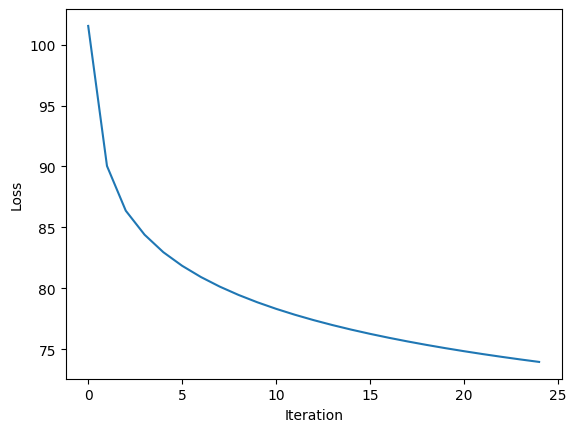

In [65]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [66]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))



YOUR features! Training accuracy = 0.89, test accuracy = 0.92


In [67]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

Cov_student_test = compute_laplace_Cov(features_student(X_test), y_test, w_MAP_student)
print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())
print("YOUR features! Model evidence estimate(test):",
      compute_laplace_log_evidence(features_student(X_test), y_test, w_MAP_student, Cov_student_test).item())


YOUR features! Model evidence estimate: -54.03155517578125
YOUR features! Model evidence estimate(test): -29.03219985961914


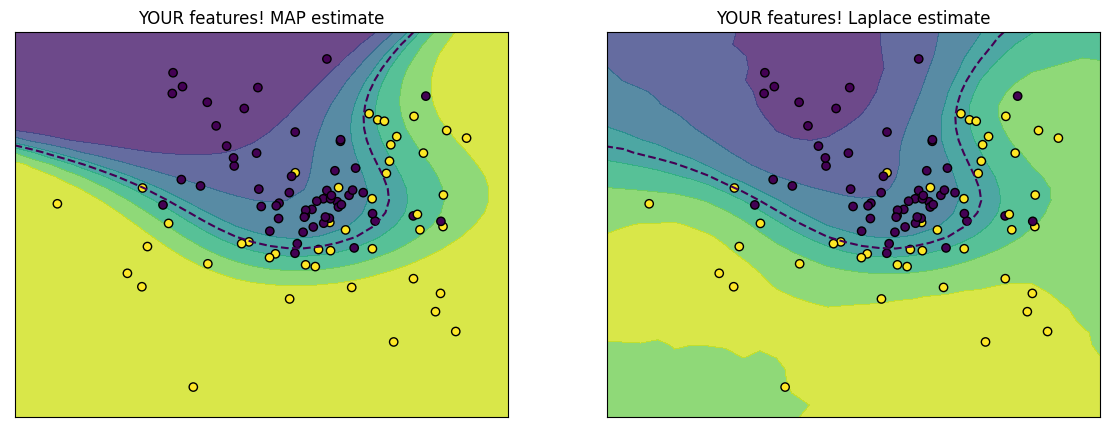

In [68]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

## Question 1

The aim of producing a model is not to fit the training data very well but to get a model to synthesise a general pattern from the data, despite the noise. Thus, in feature selection, we aim to find features that perform well on data the model has not seen during training. As such, the prediction accuracy on the test set, a set of data not trained on, provides an estimate of the prediction accuracy on the population data. This metric assumes that the test data is an unbiased sample of the population data.

First, we find the best prediction accuracy on test data to decide on a feature mapping. The feature mapping chosen is an order three polynomial expansion. When compared with the other feature mappings, it maximised test accuracy.

Additionally, Comparing model evidence, $P(\mathcal{D_{test}})$, gives a probabilistic interpretation of whether the model explains the data. This is calculated by integrating the distribution of model parameters on the test data. This enables comparison of the model's estimation quality on data, given a distribution of parameters.
$$
P(\mathcal{D}) = \int P(\mathcal{D}, \textbf{\theta}) d\textbf{\theta}
$$
This integral is, in general hard. However, the Laplace approximation of the posterior has a closed-form solution. This gives an estimate of the evidence of the model. The accuracy of the estimate is dependent on how normal the posterior is. The model with the highest evidence indicates the best feature set.

These methods, in many cases, might produce a similar ranking. However, where there are ties in accuracy due to prediction accuracy taking discrete values, the model evidence estimate can attribute higher probabilities to classification models with greater separation from the model's boundary and penalise explicitly for increased model complexity. However, The Laplace approximation can fail as there is nothing governing posteriors to be Gaussian, and this will provide an inaccurate estimate of the model's evidence.

## Question 2
Overfitting is a problem; when introducing higher feature dimensions, the model becomes more flexible and can better fit the training dataset. However, this does not correspond to increased accuracy on the test set data. As such, the model learns the specifics of the sample set not the general behaviour of the population.
Comparing the fit of a Laplace approximation to a MAP estimate will typically not substantially change the location of the boundary given sufficient samples, as the Laplace estimate describes Multivariate Gaussian parameter distributions centred on the MAP. Thus, when the expected parameters are calculated from the Laplace approximation, they should be approximately equal to the MAP estimate. So there is no benefit regarding overfitting directly.

#### Ignore the following cells. They are used by the grading system.

In [69]:
# (GRADING)

In [70]:
# (GRADING)